In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq   # For reading train_parquet file
import os
import numba 
from scipy.signal import find_peaks, argrelmax
import random

In [2]:
data_folder = '../../input'
os.listdir(data_folder)

['metadata_train.csv', 'train.parquet', 'VSB Power Line Fault Detection']

In [3]:
df_meta = pd.read_csv(data_folder + '/metadata_train.csv')

In [4]:
%%time
# Load Parquet file containing 800k signal measurements for each signal_id in df_meta

parq_data = pq.read_pandas(data_folder + '/train.parquet').to_pandas()

Wall time: 14.7 s


## Understanding Data
* **Information on meta_data and signal_data**
* **Interpretation of data distribution**
* **Review Visual patterns of fault(PD-partial discharge positive) and fault-free(PD-free) signals**  
* **Review peaks in sample signals**


### Information on meta_data and signal_data

In [5]:
df_meta.describe()

,signal_id,id_measurement,phase,target
count,8712.000000,8712.000000,8712.000000,8712.000000
mean,4355.500000,1451.500000,1.000000,0.060262
std,2515.082106,838.360658,0.816543,0.237985
min,0.000000,0.000000,0.000000,0.000000
25%,2177.750000,725.750000,0.000000,0.000000
50%,4355.500000,1451.500000,1.000000,0.000000
75%,6533.250000,2177.250000,2.000000,0.000000
max,8711.000000,2903.000000,2.000000,1.000000


In [6]:
df_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [7]:
parq_data.shape

(800000, 8712)

In [8]:
col = [str(i) for i in range(5)]
parq_data[col].head()

,0,1,2,3,4
0,18,1,-19,-16,-5
1,18,0,-19,-17,-6
2,17,-1,-20,-17,-6
3,18,1,-19,-16,-5
4,18,0,-19,-16,-5


In [9]:
df_meta.corr()

,signal_id,id_measurement,phase,target
signal_id,1.000000,1.000000,0.000325,-0.023992
id_measurement,1.000000,1.000000,0.000000,-0.023993
phase,0.000325,0.000000,1.000000,0.001772
target,-0.023992,-0.023993,0.001772,1.000000


### Interpretation of data 
Understanding from above set of information
* Signal data (parq_data) contains 3 phase signal measurements.
* Each signal_id has 800k measurements in parq_data.
* parq_data has 3 phase (0, 1, 2) signal measurements for each of id_measurement. 
* Above table highlights that target (1- PD fault or 0- PD free) is independent of phase and id_measurement

In [10]:
# Fault and Fault free signal_ids for understanding of signal patterns

fault_sid = df_meta.loc[df_meta.target == 1, 'signal_id']
fault_free_sid = df_meta.loc[df_meta.target == 0, 'signal_id']
print(fault_sid.shape, fault_free_sid.shape)

(525,) (8187,)


In [11]:
@numba.jit(nopython=True)
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    Source : https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [12]:
def get_peaks_troughs(flat_signal, prominence=8, distance=100):
    """
    Return peaks and troughs of given flat_signals
    """
    (pks_idx, _) = find_peaks(flat_signal, prominence=prominence, distance=distance)
    (trough_idx, _)  = find_peaks(flat_signal * -1, prominence=prominence, distance=distance)
    return pks_idx, trough_idx


In [13]:
def plot_signals_n_peaks(sample, pks_idx, trough_idx, sub_plot_title=None, title=None, color='aqua'):
    """
    To plot sample signals and its peaks & troughs
    Sample                      : list of Sample signals measurements - 2D list
    pks_idx                     : peaks index list
    trough_idx                  : trough index list
    sub_plot_title              : list of title for for the sub plots
    title                       : Title of the plot
    """
    sz = len(sample)
    fig, axs = plt.subplots(sz,1, figsize=(24,sz*6))
    for i, ax in enumerate(axs) :
        ax.plot(sample[i], color=color, alpha=0.7)
        ax.scatter(pks_idx[i], sample[i][pks_idx[i]], color='red')
        ax.scatter(trough_idx[i], sample[i][trough_idx[i]], color='red')
        ax.set_title(sub_plot_title[i], fontsize=16)

    fig.suptitle(title, fontsize=20)
    plt.show()

### Review Visual patterns of fault(PD-partial discharge positive) and fault-free(PD-free) signals & Review peaks in sample signals

In [14]:
# Identify 3 sample signals measurements for plotting to understand patterns
# Flattern and find peaks of the sample (PD) Fault FREE signal measurements

sids = fault_free_sid.sample(2,random_state=55)   # Get random sample (PD)fault free signal_ids of measurements
sample_df = parq_data[map(str, sids)]             # assign measurement data of the samples

prominence, distance, cols = 6, 100, sample_df.columns     # Set values for flatten and find_peaks of signals 
sample, flat_sample, pks_idx, trough_idx = [], [], [], []  # initialize lists for flatten and peaks signals

for i, col in enumerate(cols):
    sample.append(sample_df[col].values)
    flat_sample.append(flatiron(sample[i].astype(np.float)))
    p_idx, t_idx = get_peaks_troughs(flat_sample[i])
    pks_idx.append(p_idx)
    trough_idx.append(t_idx)


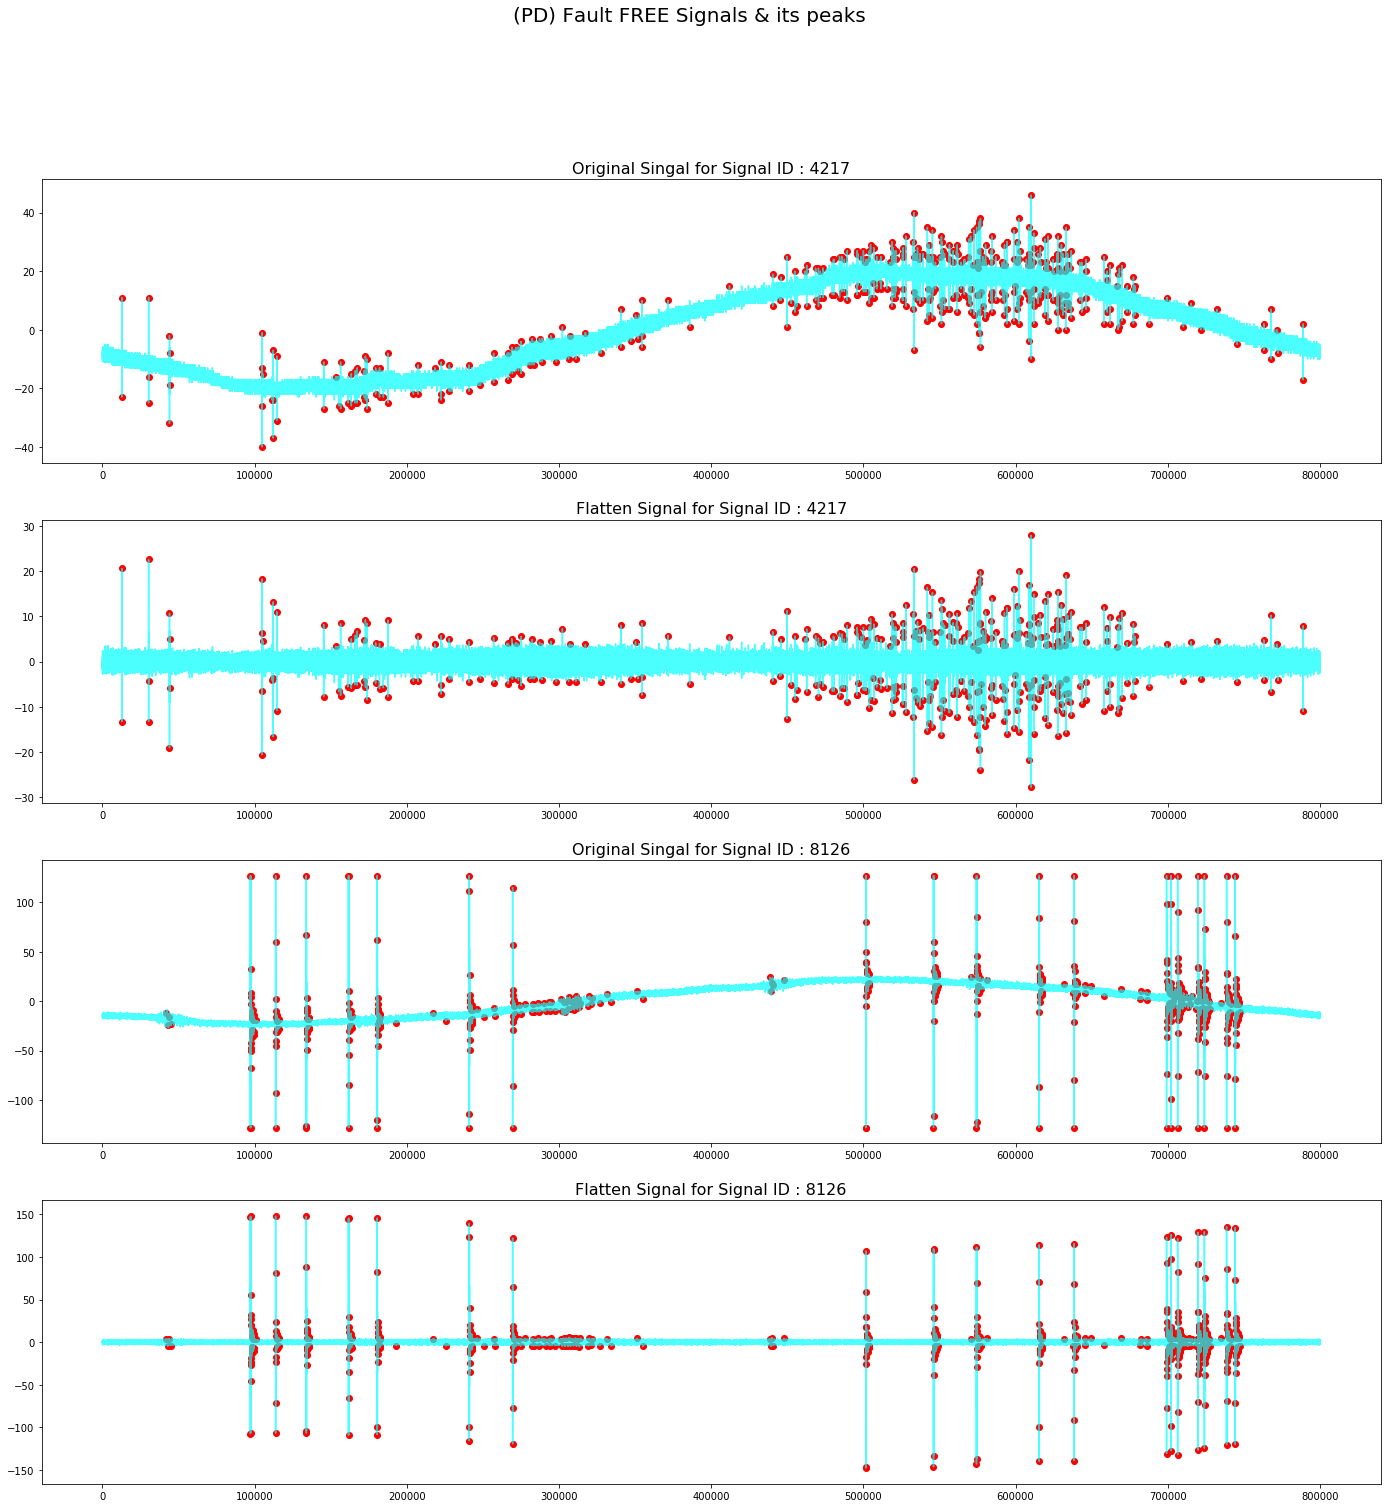

In [15]:
# Plot PD Fault FREE sample signals

t1 = ['Original Singal for Signal ID : ' + str(sid) for sid in sids]
t2 = ['Flatten Signal for Signal ID : ' + str(sid) for sid in sids]
sub_plot_title = [item for sublist in zip(t1,t2) for item in sublist]

c_sample = [item for sublist in zip(sample, flat_sample) for item in sublist]
c_pks_idx = [item for sublist in zip(pks_idx, pks_idx) for item in sublist]
c_trough_idx = [item for sublist in zip(trough_idx, trough_idx) for item in sublist]

plot_signals_n_peaks(c_sample, c_pks_idx, c_trough_idx, sub_plot_title, '(PD) Fault FREE Signals & its peaks')

In [16]:
# Identify 3 sample signals measurements for plotting to understanding patterns
# Flattern and find peaks of the sample (PD) FAULT signal measurements

sids = fault_sid.sample(2,random_state=55)     # Get random sample (PD)fault signal_ids of measurements
sample_df = parq_data[map(str, sids)]             # assign measurement data of the samples

prominence, distance, cols = 6, 100, sample_df.columns        # Set values for flatten and find_peaks of signals 
sample, flat_sample, pks_idx, trough_idx = [], [], [], []  # initialize lists for flatten and peaks signals

for i, col in enumerate(cols):
    sample.append(sample_df[col].values)
    flat_sample.append(flatiron(sample[i].astype(np.float)))
    p_idx, t_idx = get_peaks_troughs(flat_sample[i])
    pks_idx.append(p_idx)
    trough_idx.append(t_idx)


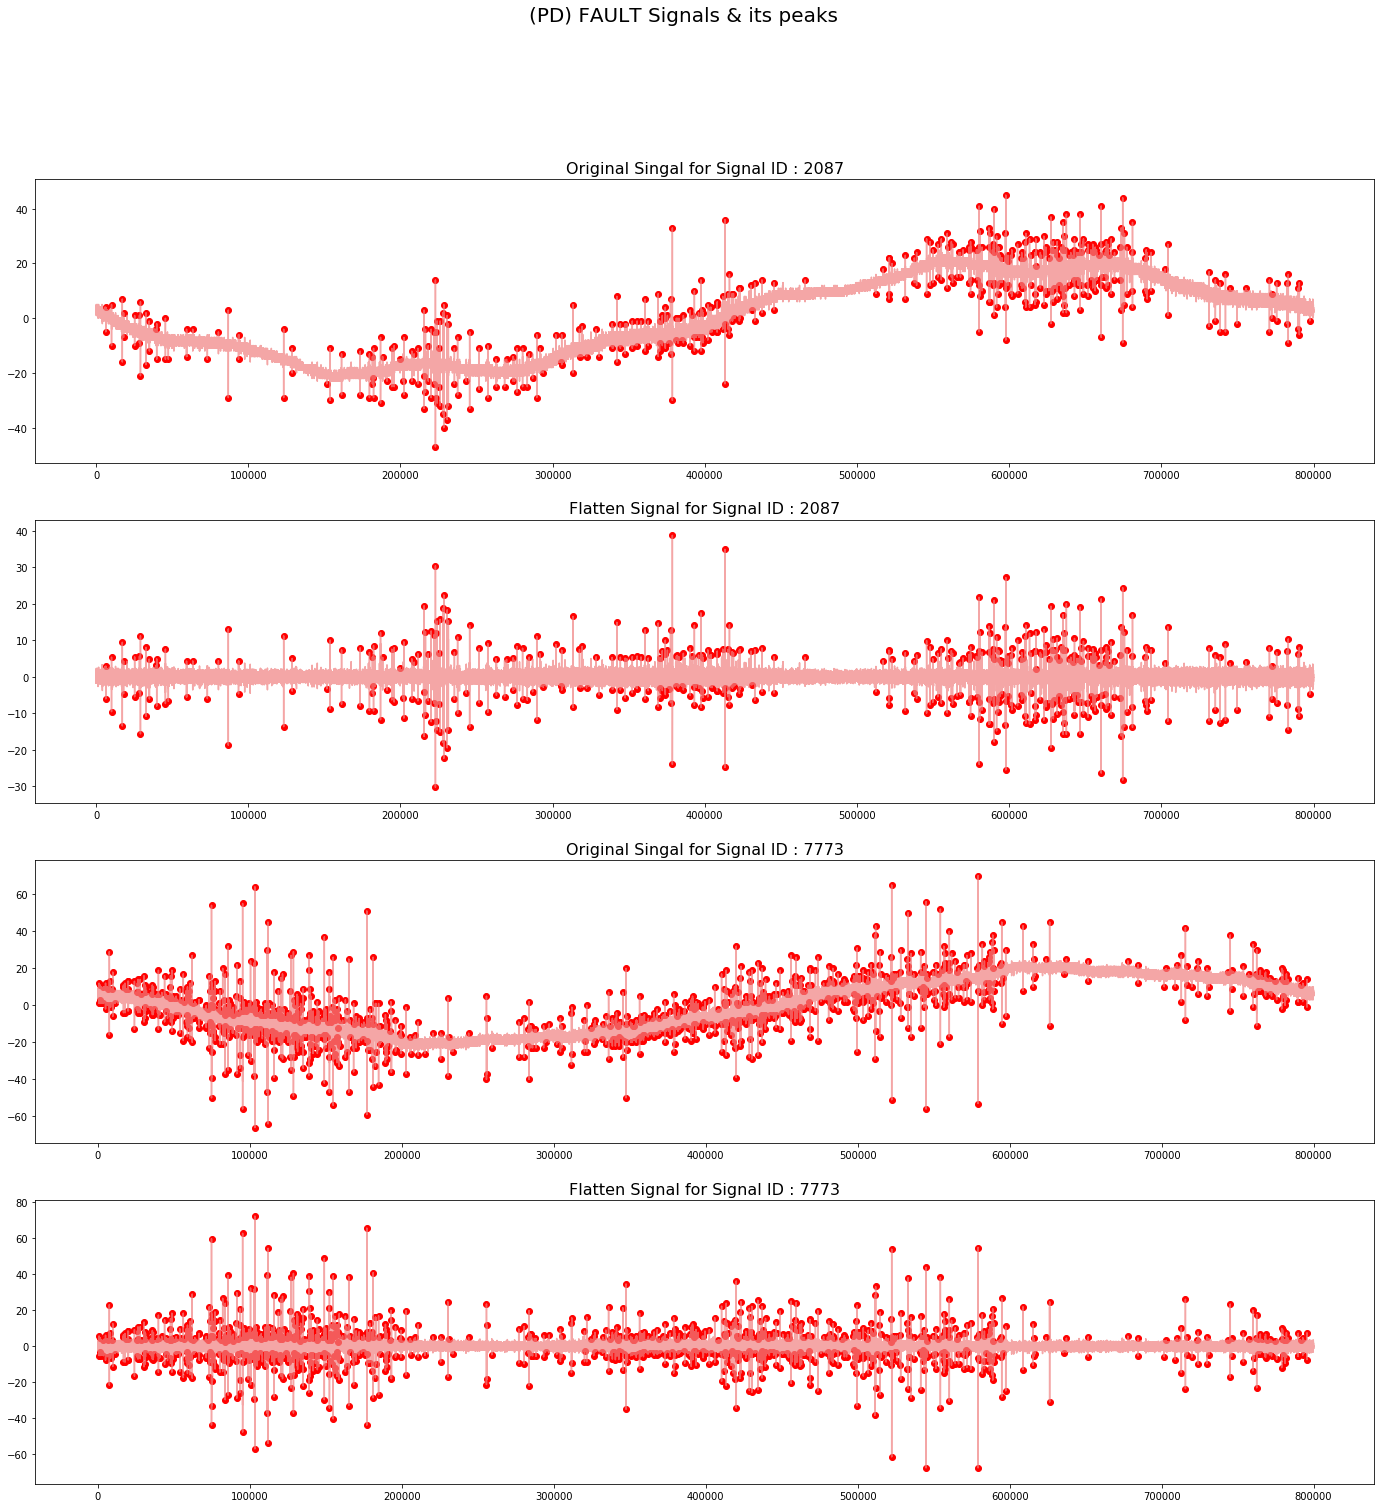

In [17]:
# Plot PD Fault sample signals

t1 = ['Original Singal for Signal ID : ' + str(sid) for sid in sids]
t2 = ['Flatten Signal for Signal ID : ' + str(sid) for sid in sids]
sub_plot_title = [item for sublist in zip(t1,t2) for item in sublist]

c_sample = [item for sublist in zip(sample, flat_sample) for item in sublist]
c_pks_idx = [item for sublist in zip(pks_idx, pks_idx) for item in sublist]
c_trough_idx = [item for sublist in zip(trough_idx, trough_idx) for item in sublist]

plot_signals_n_peaks(c_sample, c_pks_idx, c_trough_idx, sub_plot_title, '(PD) FAULT Signals & its peaks', color='lightcoral')